In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as stm
import statsmodels
import datetime as dt
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
register_matplotlib_converters()
from time import time

In [4]:
monthly=pd.read_csv('MedicineData.csv')

In [5]:
def print_shape(data):
    print('Rows:',data.shape[0])
    print('Columns:',data.shape[1])

In [6]:
print(print_shape(monthly))

Rows: 324
Columns: 2
None


In [7]:
print(monthly)

          date   R03
0     1/1/1992  1509
1     2/1/1992  1541
2     3/1/1992  1597
3     4/1/1992  1675
4     5/1/1992  1822
..         ...   ...
319   8/1/2018  4898
320   9/1/2018  4598
321  10/1/2018  4737
322  11/1/2018  5130
323  12/1/2018  6370

[324 rows x 2 columns]


Performing some descriptive statistics, we have

In [8]:
monthly.describe()

,R03
count,324.000000
mean,2972.895062
std,1010.218574
min,1501.000000
25%,2109.000000
50%,2791.000000
75%,3627.250000
max,6370.000000


In [9]:
monthly.isnull().sum()

date    0
R03     0
dtype: int64

Hence, there are no null values in the dataframe.

In [10]:
monthly.sample(4)

,date,R03
49,2/1/1996,1652
1,2/1/1992,1541
118,11/1/2001,2638
16,5/1/1993,1796


In [11]:
type(monthly)

pandas.core.frame.DataFrame

In [12]:
type(monthly.loc[:,"date"])

pandas.core.series.Series

In [13]:
monthly['date']

0       1/1/1992
1       2/1/1992
2       3/1/1992
3       4/1/1992
4       5/1/1992
         ...    
319     8/1/2018
320     9/1/2018
321    10/1/2018
322    11/1/2018
323    12/1/2018
Name: date, Length: 324, dtype: object

Converting the datatype of date field from object to datetime, in order to perform time series based functionalities.

In [14]:
monthly['date']=pd.to_datetime(monthly['date'])

In [15]:
monthly['date']

0     1992-01-01
1     1992-02-01
2     1992-03-01
3     1992-04-01
4     1992-05-01
         ...    
319   2018-08-01
320   2018-09-01
321   2018-10-01
322   2018-11-01
323   2018-12-01
Name: date, Length: 324, dtype: datetime64[ns]

In [16]:
#extracting the year, month and day from the date values
monthly['year'] = monthly['date'].dt.year
monthly['month'] = monthly['date'].dt.month
monthly['day'] = monthly['date'].dt.day

In [17]:
#setting the date values as index of the dataframe, to perform time-series analysis
monthly.set_index(monthly['date'], inplace=True)

In [18]:
monthly.sample(5)

,date,R03,year,month,day
date,,,,,
1992-09-01,1992-09-01,1770,1992,9,1
2004-06-01,2004-06-01,2643,2004,6,1
1998-09-01,1998-09-01,2031,1998,9,1
1995-06-01,1995-06-01,1863,1995,6,1
2006-01-01,2006-01-01,2424,2006,1,1


In [19]:
monthly.tail()

,date,R03,year,month,day
date,,,,,
2018-08-01,2018-08-01,4898,2018,8,1
2018-09-01,2018-09-01,4598,2018,9,1
2018-10-01,2018-10-01,4737,2018,10,1
2018-11-01,2018-11-01,5130,2018,11,1
2018-12-01,2018-12-01,6370,2018,12,1


In [20]:
monthly.columns

Index(['date', 'R03', 'year', 'month', 'day'], dtype='object')

In [21]:
col_list=['R03']

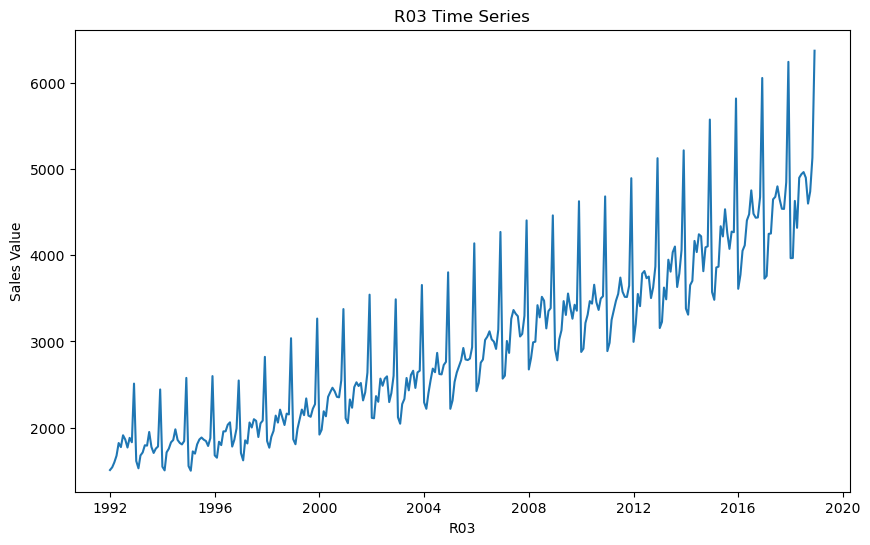

In [22]:
#Plotting the time series of the R03 column
for col in col_list:
    plt.figure(figsize=(10,6))
    plt.plot(monthly.index,monthly[col])
    plt.title(f'{col} Time Series')
    plt.xlabel(col)
    plt.ylabel('Sales Value')
    plt.show()
              

In [23]:
window_size=4
monthly['SMA']=monthly['R03'].rolling(window=window_size, min_periods=1).mean()

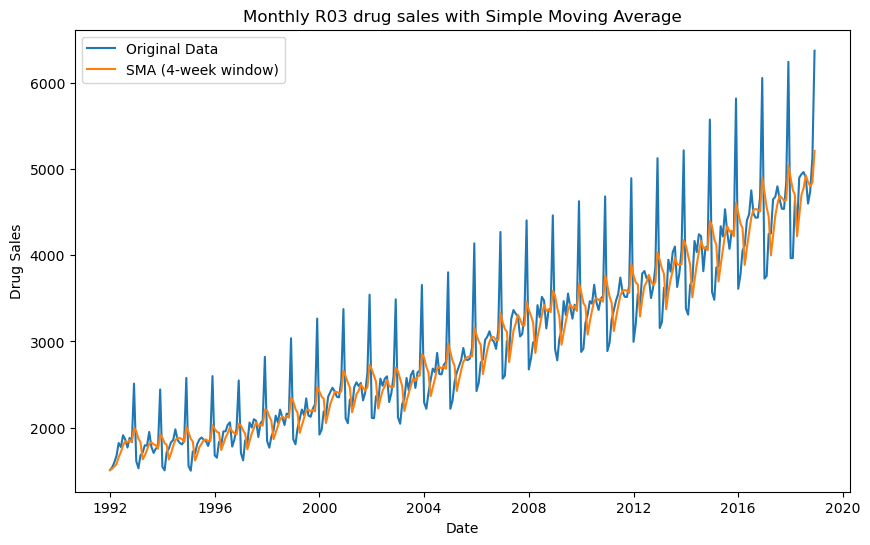

In [24]:
#plotting the R03 sales and the SMA values

plt.figure(figsize=(10,6))
plt.plot(monthly.index,monthly['R03'], label='Original Data')
plt.plot(monthly.index,monthly['SMA'],label=f'SMA ({window_size}-week window)')
plt.title('Monthly R03 drug sales with Simple Moving Average')
plt.xlabel('Date')
plt.ylabel('Drug Sales')
plt.legend()
plt.show()

The simple moving average smoothens out the curve by a huge extent and removes noise, which helps us see that the sale of the drug is consistent and slowly increasing over the years, with a peak in the sales at the end of every year.

In [25]:
def perform_adf_test(series):
    result=adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [27]:
perform_adf_test(monthly['R03'])

ADF Statistic: 2.864309
p-value: 1.000000


In [28]:
perform_adf_test(monthly['SMA'])

ADF Statistic: 2.436951
p-value: 0.999027


In [29]:
#Checking for ACF and PACF plots

monthly=monthly.asfreq(pd.infer_freq(monthly.index))

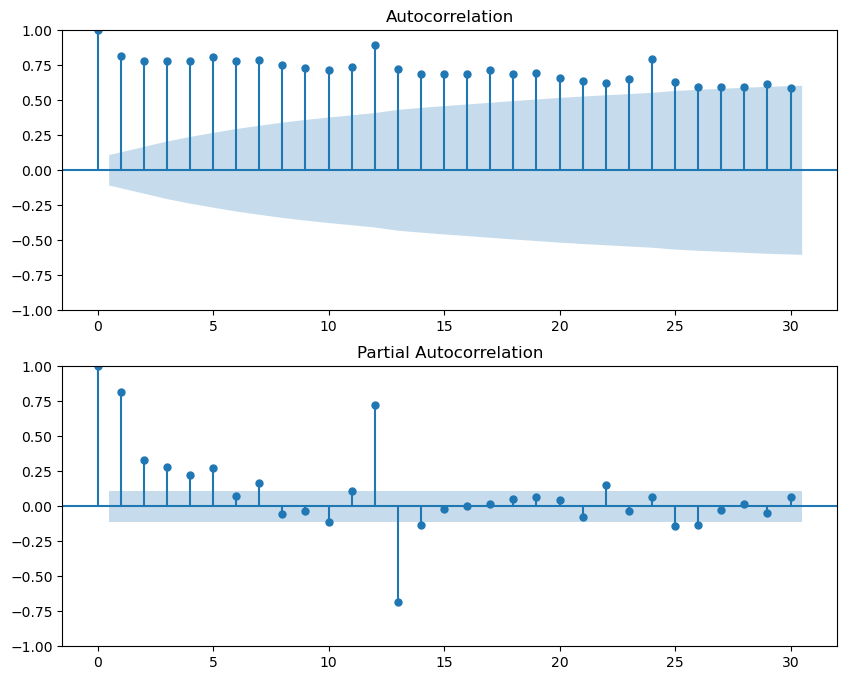

In [30]:
#Plotting ACF and PACF of the differenced series

fig, (ax1,ax2)=plt.subplots(2,1,figsize=(10,8))
stm.graphics.tsa.plot_acf(monthly['R03'],lags=30, ax=ax1)
stm.graphics.tsa.plot_pacf(monthly['R03'],lags=30,ax=ax2)
plt.show()

Using AR(1) or MA(1) models to fit our time series

In [32]:
#Train test split to check the efficacy of the models

train_end=dt.datetime(2013,7,1)
train_data=monthly[:train_end]
test_data=monthly[train_end+dt.timedelta(days=1):]

Not using ARMA model because the p values for coefficients of MA model are more than 0.05, that's why rejecting those values and sticking to AR model

In [33]:
model=statsmodels.tsa.ar_model.AutoReg(train_data['R03'],lags=1)
results=model.fit()

In [34]:
print(results.summary())

                            AutoReg Model Results                             
Dep. Variable:                    R03   No. Observations:                  259
Model:                     AutoReg(1)   Log Likelihood               -1960.268
Method:               Conditional MLE   S.D. of innovations            482.509
Date:                Thu, 08 Aug 2024   AIC                           3926.536
Time:                        02:16:37   BIC                           3937.195
Sample:                    02-01-1992   HQIC                          3930.822
                         - 07-01-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        648.6641    111.387      5.823      0.000     430.349     866.980
R03.L1         0.7554      0.041     18.399      0.000       0.675       0.836
                                    Roots           

In [35]:
test_data

,date,R03,year,month,day,SMA
date,,,,,,
2013-08-01,2013-08-01,4100,2013,8,1,3972.50
2013-09-01,2013-09-01,3631,2013,9,1,3893.50
2013-10-01,2013-10-01,3787,2013,10,1,3888.00
2013-11-01,2013-11-01,4059,2013,11,1,3894.25
2013-12-01,2013-12-01,5215,2013,12,1,4173.00
...,...,...,...,...,...,...
2018-08-01,2018-08-01,4898,2018,8,1,4924.25
2018-09-01,2018-09-01,4598,2018,9,1,4849.50
2018-10-01,2018-10-01,4737,2018,10,1,4799.00


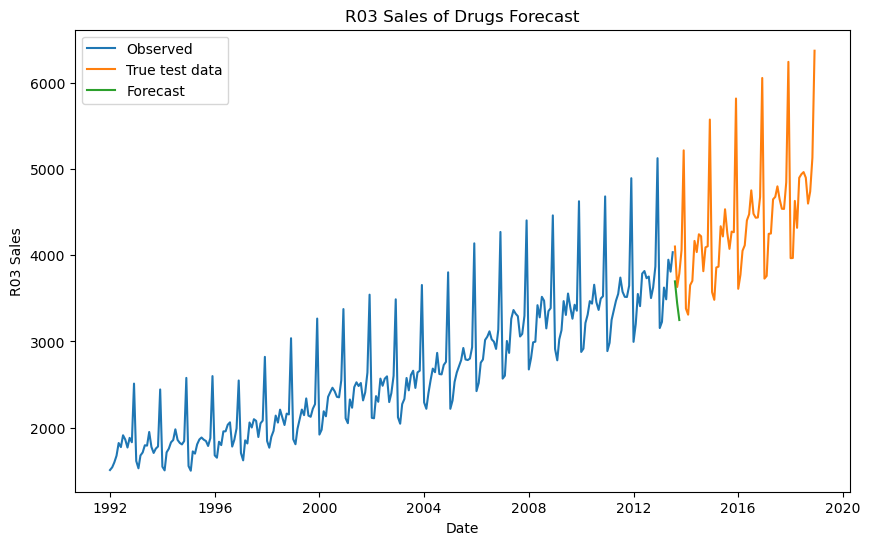

In [39]:
forecast=results.forecast(steps=3)
#had to change steps from 1 to 3 because forecast is barely visible with step count 1.
#plotting the forecast

plt.figure(figsize=(10,6))
plt.plot(train_data.index, train_data['R03'], label='Observed')
plt.plot(test_data.index, test_data['R03'], label='True test data')
plt.plot(forecast.index, forecast, label='Forecast')
plt.title('R03 Sales of Drugs Forecast')
plt.xlabel('Date')
plt.ylabel('R03 Sales')
plt.legend()
plt.show()

In [40]:
forecast

2013-08-01    3696.093940
2013-09-01    3440.827456
2013-10-01    3247.989903
Freq: MS, dtype: float64

In [41]:
residuals=test_data['R03']-forecast

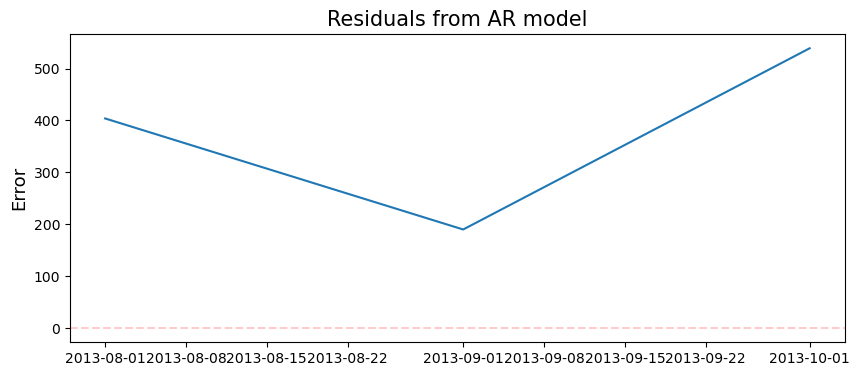

In [42]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR model', fontsize=15)
plt.ylabel('Error', fontsize=13)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

In [43]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 404.0782046761839
